In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

file_path = '/content/animal_reports_population.csv'
animal_reports_df = pd.read_csv(file_path)

animal_reports_df['Date'] = pd.to_datetime(animal_reports_df['Date'], errors='coerce')
animal_reports_df['Year_Month'] = animal_reports_df['Date'].dt.to_period('M').dt.to_timestamp()

animal_monthly_counts = animal_reports_df.groupby(['Animal', 'Year_Month']).size().reset_index(name='Count')

def prepare_data(animal_type):
    data = animal_monthly_counts[animal_monthly_counts['Animal'] == animal_type]
    data.index = pd.date_range(start=data['Year_Month'].min(), periods=len(data), freq='M')
    return data['Count']

dog_counts = prepare_data('dog')
cat_counts = prepare_data('cat')
bird_counts = prepare_data('bird')
raccoon_counts = prepare_data('raccoon')
bat_counts = prepare_data('bat')

In [2]:
def fit_sarima(series, order, seasonal_order, steps):
    model = SARIMAX(series, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=steps)
    forecast = np.where(forecast < 0, 0, forecast)
    return forecast

In [3]:
sarima_order = (1, 1, 1)
sarima_seasonal_order = (1, 1, 1, 12)  # Assuming an annual seasonality
forecast_horizon = 12  # March to December

# Fit and Predict
dog_forecast = fit_sarima(dog_counts, sarima_order, sarima_seasonal_order, forecast_horizon)
cat_forecast = fit_sarima(cat_counts, sarima_order, sarima_seasonal_order, forecast_horizon)
raccoon_forecast = fit_sarima(raccoon_counts, sarima_order, sarima_seasonal_order, forecast_horizon)
bird_forecast = fit_sarima(bird_counts, sarima_order, sarima_seasonal_order, forecast_horizon)
bat_forecast = fit_sarima(bat_counts, sarima_order, sarima_seasonal_order, forecast_horizon)

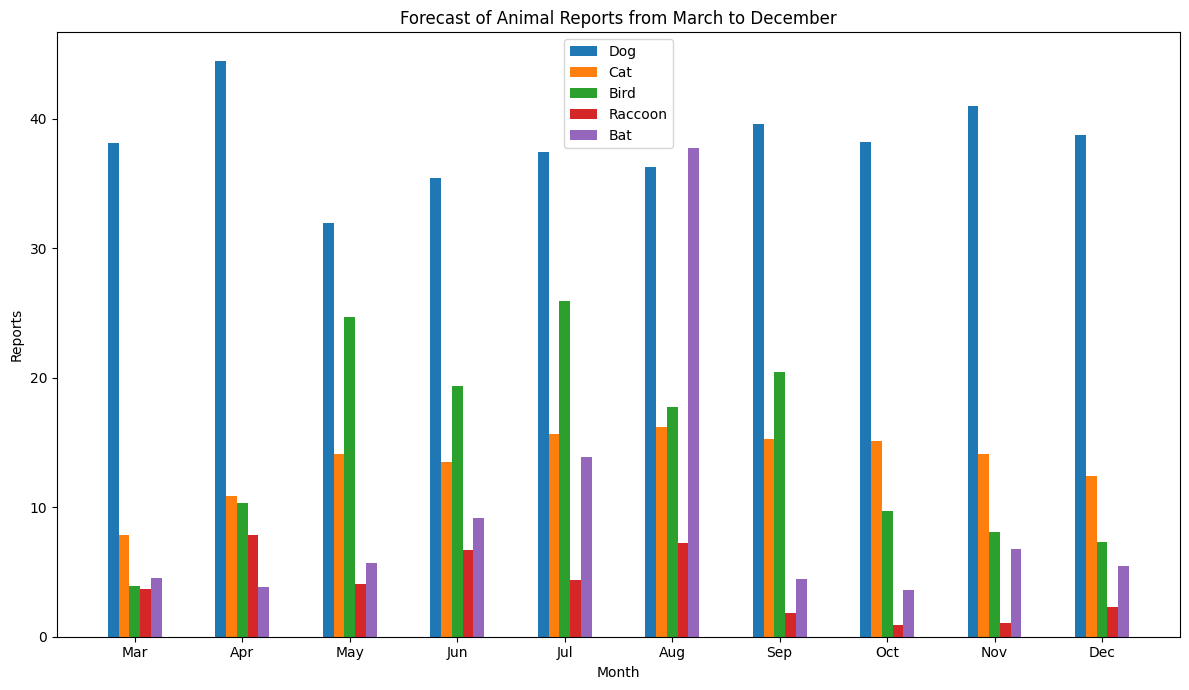

In [4]:
import matplotlib.pyplot as plt
import numpy as np

full_months = ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

full_year_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

start_indices = {
    'dog': full_year_months.index('Mar'),  # Starts forecasting from March
    'bat': full_year_months.index('Aug'),
    'cat': full_year_months.index('Nov'),
    'raccoon': full_year_months.index('Oct'),
    'bird': full_year_months.index('Dec')
}

# Forecast data arrays
dog_cases = np.array(dog_forecast)
cat_cases = np.array(cat_forecast)
raccoon_cases = np.array(raccoon_forecast)
bird_cases = np.array(bird_forecast)
bat_cases = np.array(bat_forecast)

# Set up the figure for plotting
fig, ax = plt.subplots(figsize=(12, 7))
bar_width = 0.1

for i, (animal, cases) in enumerate(zip(['dog', 'cat', 'bird', 'raccoon', 'bat'], [dog_cases, cat_cases, bird_cases, raccoon_cases, bat_cases])):
    offset = (i - 2) * 0.1
    start_index = start_indices[animal]

    month_indices = [(start_index + j) % 12 for j in range(len(cases))]  # Full wrap around

    valid_indices = [idx for idx in month_indices if 0 <= idx <= 9]

    valid_cases = cases[:len(valid_indices)]
    ax.bar(np.array(valid_indices) + offset, valid_cases, width=bar_width, label=animal.capitalize())


ax.set_xlabel('Month')
ax.set_ylabel('Reports')
ax.set_title('Forecast of Animal Reports from March to December')

ax.set_xticks(range(len(full_months)))
ax.set_xticklabels(full_months)

ax.legend()

fig.tight_layout()

plt.show()
